In [0]:
import re
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import datetime

import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn import tree

from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score



In [0]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/My Drive/DS/googleplaystore.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Exploration

Exploring our data

In [0]:
# Print first rows from data

data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [0]:
# Print last rows from data

data.tail(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10831,payermonstationnement.fr,MAPS_AND_NAVIGATION,NaN,38,9.8M,"5,000+",Free,0,Everyone,Maps & Navigation,"June 13, 2018",2.0.148.0,4.0 and up
10832,FR Tides,WEATHER,3.8,1195,582k,"100,000+",Free,0,Everyone,Weather,"February 16, 2014",6.0,2.1 and up
10833,Chemin (fr),BOOKS_AND_REFERENCE,4.8,44,619k,"1,000+",Free,0,Everyone,Books & Reference,"March 23, 2014",0.8,2.2 and up
10834,FR Calculator,FAMILY,4.0,7,2.6M,500+,Free,0,Everyone,Education,"June 18, 2017",1.0.0,4.1 and up
10835,FR Forms,BUSINESS,NaN,0,9.6M,10+,Free,0,Everyone,Business,"September 29, 2016",1.1.5,4.0 and up
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device
10840,iHoroscope - 2018 Daily Horoscope & Astrology,LIFESTYLE,4.5,398307,19M,"10,000,000+",Free,0,Everyone,Lifestyle,"July 25, 2018",Varies with device,Varies with device


In [0]:
# Shape of data i.e. rows and columns

data.shape

(10841, 13)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Looks like there are missing values in "Rating", "Type", "Content Rating", "Current Ver" and " Android Ver".

In [0]:
# Checking null values

data.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [0]:
data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [0]:
# Describing our data

data.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [0]:
# Columns present in our data

data.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

## Data Cleaning

*   Removing null values
*   Filling missing values
*   Remove certain characters from the string and convert it into usable format.






In [0]:
# The best way to fill missing values might be using the median instead of mean

data['Rating'] = data['Rating'].fillna(data['Rating'].median())

In [0]:
# Lets convert all the versions in the format number.number to simplify the data
# We have to clean all non numerical values & unicode charachters 

replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
    data['Current Ver'] = data['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
    data['Current Ver'] = data['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

data['Current Ver'] = data['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
data['Current Ver'] = data['Current Ver'].fillna(data['Current Ver'].median())


In [0]:
# Count the number of unique values in category column 

data['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [0]:
# Check the record  of unreasonable value which is 1.9
i = data[data['Category'] == '1.9'].index
data.loc[i]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0,NaN


It's obvious that the first value of this record is missing (App name) and all other values are respectively propagated backward starting from "Category" towards the "Current Ver"; and the last column which is "Android Ver" is left null. It's better to drop the entire recored instead of consider these unreasonable values while cleaning each column!



In [0]:
# Drop this bad column
data = data.drop(i)

In [0]:
# Removing NaN values
data = data[pd.notnull(data['Last Updated'])]
data = data[pd.notnull(data['Content Rating'])]

## Plotting

1.) Count of application according to Category

Text(0.5, 1.0, 'Count of application according to category')

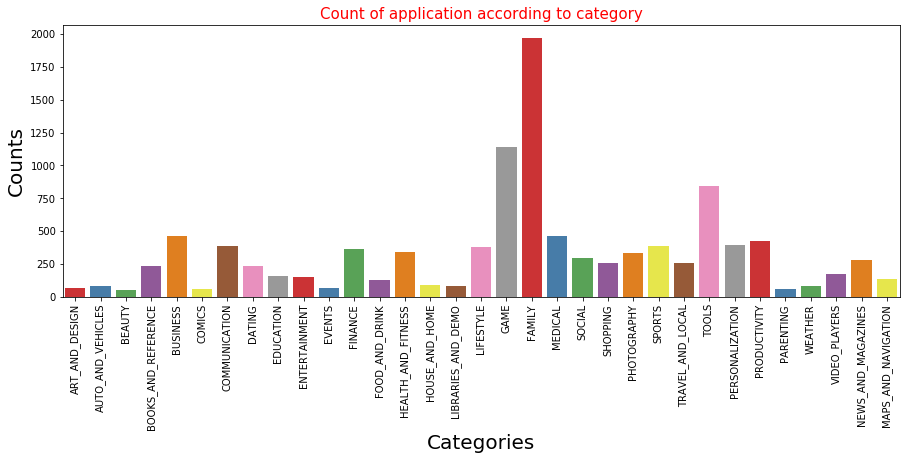

In [0]:
plt.figure(figsize=(15, 5))
sns.countplot(x='Category', data=data, palette='Set1')
plt.xticks(rotation=90)
plt.xlabel('Categories', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.title('Count of application according to category', fontsize=15, color='r')

Seems like family and games category have quite large number 

2.) Let's look at the Rating distribution

Text(0.5, 1.0, 'Distribution of Rating')

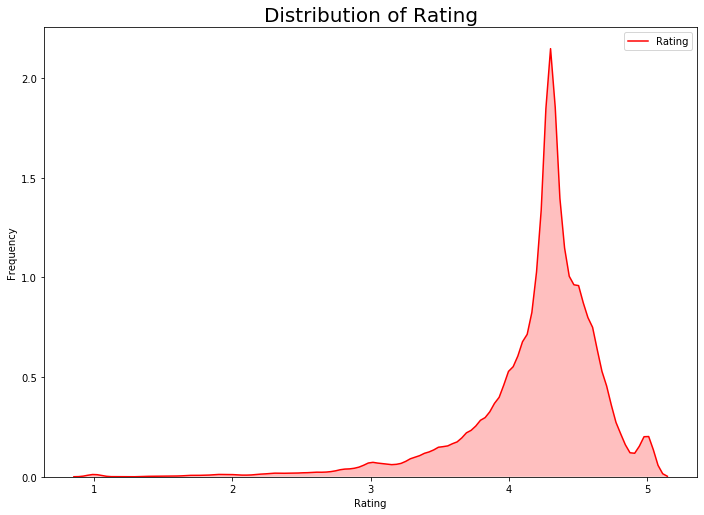

In [0]:
from pylab import rcParams

rcParams['figure.figsize'] = 11.7,8.27
g = sns.kdeplot(data.Rating, color="Red", shade = True)
g.set_xlabel("Rating")
g.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 20)

3.) Let's check out the percentage of free apps in data

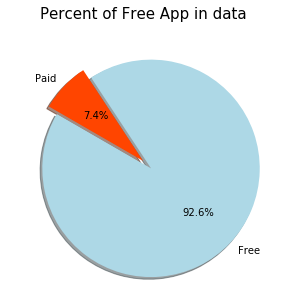

In [0]:
labels =data['Type'].value_counts(sort = True).index
sizes = data['Type'].value_counts(sort = True)


colors = ["lightblue","orangered"]
explode = (0.1,0)  # explode 1st slice
 
rcParams['figure.figsize'] = 5,5
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=150,)

plt.title('Percent of Free App in data', size = 15)
plt.show()

Majority of the apps are free


4.) Content Distribution

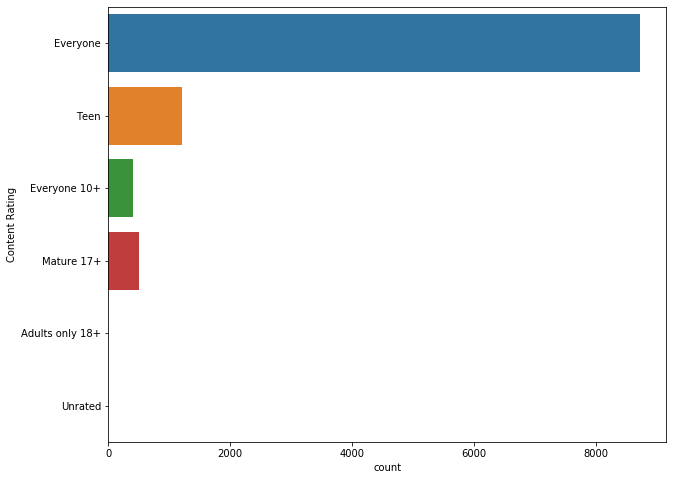

In [0]:
plt.figure(figsize=(10,8))
ax = sns.countplot(y='Content Rating', data=data)

## Categorical Data Encoding

We need to convert categorical features (strings) to numerical features (numbers). 

Many machine learning algorithms can support categorical values without further manipulation but there are many more algorithms that do not. We need to make all data ready for the model, so we will convert categorical variables (variables that stored as text values) into numerical variables. 

In [0]:
# App values encoding

LE = preprocessing.LabelEncoder()
data['App'] = LE.fit_transform(data['App'])

In [0]:
# Category features encoding

CategoryList = data['Category'].unique().tolist() 
CategoryList = ['cat_' + word for word in CategoryList]
data = pd.concat([data, pd.get_dummies(data['Category'], prefix='cat')], axis=1)

In [0]:
# Genres features encoding

LE = preprocessing.LabelEncoder()
data['Genres'] = LE.fit_transform(data['Genres'])

In [0]:
# Content Rating features encoding

LE = preprocessing.LabelEncoder()
data['Content Rating'] = LE.fit_transform(data['Content Rating'])


In [0]:
# Type encoding

data['Type'] = pd.get_dummies(data['Type'])

In [0]:
# Last Updated encoding

data['Last Updated'] = data['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))


In [0]:
# Price cleaning

data['Price'] = data['Price'].apply(lambda x : x.strip('$'))

In [0]:
# Installs cleaning

data['Installs'] = data['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [0]:
# Convert kbytes to Mbytes

k_indices = data['Size'].loc[data['Size'].str.contains('k')].index.tolist()

converter = pd.DataFrame(data.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))

data.loc[k_indices,'Size'] = converter

In [0]:
# Size cleaning

data['Size'] = data['Size'].apply(lambda x: x.strip('M'))
data[data['Size'] == 'Varies with device'] = 0
data['Size'] = data['Size'].astype(float)

## Building Machine Learning Model

Preparing data

In [0]:
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(CategoryList)

X = data[features]
y = data['Rating']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

In [0]:
X_train.shape

(7588, 43)

In [0]:
y_train.shape

(7588,)

Ridge Regression


In [0]:
r_clf = Ridge(alpha=0.1, random_state=42)
r_clf.fit(X_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)

In [0]:
r_accuracy = r_clf.score(X_test, y_test)
r_accuracy

-2.79275523426645e+33

In [0]:
r_predict = r_clf.predict(X_test)
'Mean Absolute Error:', metrics.mean_absolute_error(y_test, r_predict)

('Mean Absolute Error:', 1630619667530355.5)

#### Decision Tree Regression

Decision tree regression observes features of an object and trains a model in the structure of a tree to predict data in the future to produce meaningful continuous output. Continuous output means that the output/result is not discrete, i.e., it is not represented just by a discrete, known set of numbers or values.

In [0]:
dt_clf = tree.DecisionTreeRegressor(criterion='mae', max_depth=5, min_samples_leaf=5, random_state=42)

In [0]:
dt_clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [0]:
dt_accuracy = dt_clf.score(X_test, y_test)
dt_accuracy

0.9216974647212245

In [0]:
dt_predict = dt_clf.predict(X_test)
'Mean Absolute Error:', metrics.mean_absolute_error(y_test, dt_predict)

('Mean Absolute Error:', 0.2542127921279213)

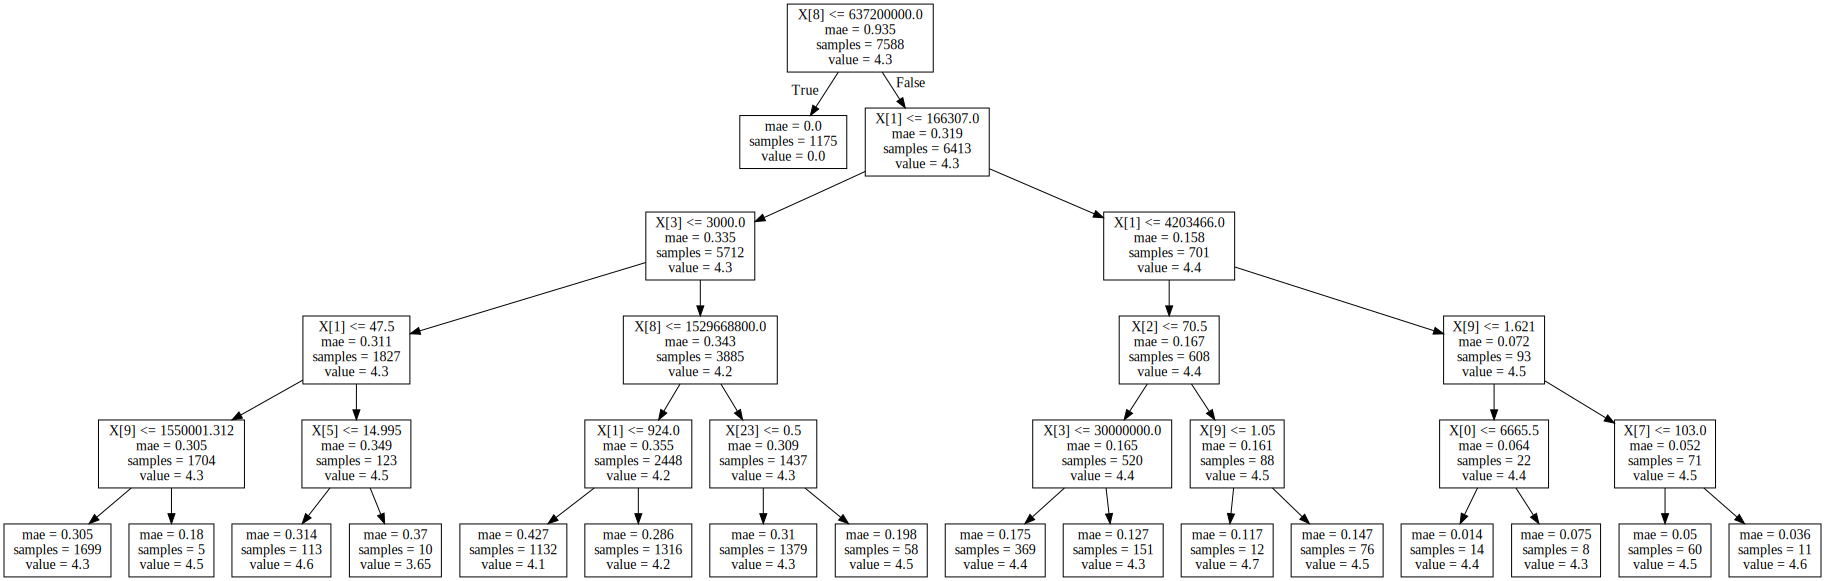

In [0]:
import graphviz 
dot_data = tree.export_graphviz(dt_clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

In [0]:
from sklearn.model_selection import GridSearchCV
grid_param = {
    'max_depth': [3, 4, 5, 6, 8],
    'min_samples_leaf': [3, 4, 5, 6, 8]
}

In [0]:
classifier = tree.DecisionTreeRegressor(criterion='mae', random_state=42)
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     cv=5,
                     n_jobs=-1)
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mae', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 8],
                         'min_samples_leaf': [3, 4, 5, 6, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [0]:
best_parameters = gd_sr.best_params_
print(best_parameters)

{'max_depth': 5, 'min_samples_leaf': 6}


#### Random Forest Regression Model

The RandomForestRegressor class of the sklearn.ensemble library is used to solve regression problems via random forest. The most important parameter of the RandomForestRegressor class is the n_estimators parameter. This parameter defines the number of trees in the random forest.


In [0]:
n_trees = [20, 50, 200, 300]
ntree_scores = []
for n in n_trees:
  print(n)
  rf_model = RandomForestRegressor(n_estimators = n, n_jobs=-1, random_state=10)
  rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
  ntree_scores.append(rf_scores) 
ntree_scores

20
50
200
300


[array([0.9280866 , 0.92562393, 0.91292065, 0.91384588, 0.91992858]),
 array([0.93194409, 0.92719752, 0.9166499 , 0.9147995 , 0.92371791]),
 array([0.93225955, 0.92836703, 0.91797859, 0.91611285, 0.92553416]),
 array([0.93255529, 0.92817901, 0.91821648, 0.91625103, 0.92576244])]

In [0]:
model = RandomForestRegressor(n_estimators = 200, n_jobs=-1, random_state=10)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

In [0]:
accuracy = model.score(X_test, y_test)
accuracy

0.9320085377856966

In [0]:
predict = model.predict(X_test)
'Mean Absolute Error:', metrics.mean_absolute_error(y_test, predict)

('Mean Absolute Error:', 0.245743388683887)

In [0]:
'Mean Squared Error:', metrics.mean_squared_error(y_test, predict)

('Mean Squared Error:', 0.162998591097786)

In [0]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predict))

('Root Mean Squared Error:', 0.4037308399141512)

##Evaluation using Cross-validation

####Random Forest

In [0]:
cv_rf_model = RandomForestRegressor(n_estimators = 200, n_jobs=-1, random_state=10)
rf_scores = cross_val_score(cv_rf_model, X, y, cv=5)

In [0]:
print("Accuracy: %0.2f (+/- %0.2f)" % (rf_scores.mean(), rf_scores.std() * 2))

Accuracy: 0.89 (+/- 0.14)


####Ridge Regression

In [0]:
cv_r_model = Ridge(alpha=10, random_state=42)
cv_r_scores = cross_val_score(cv_r_model, X, y, cv=5)

In [0]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_r_scores.mean(), cv_r_scores.std() * 2))

Accuracy: -14084629331086495008798121738108928.00 (+/- 56338517324345980035192486952435712.00)




## Feature Selection

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested. 

Three benefits of performing feature selection before modeling your data are:

*  **Reduces Overfitting:** Less redundant data means less opportunity to make decisions based on noise.
*  **Improves Accuracy:** Less misleading data means modeling accuracy improves.
*  **Reduces Training Time:** Less data means that algorithms train faster.

Filter methods

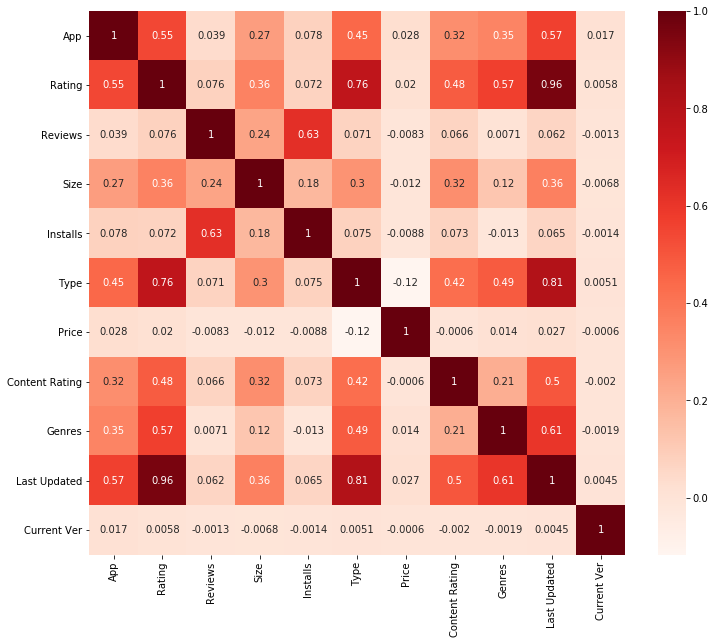

In [0]:
plt.figure(figsize=(12,10))
data1 = data.iloc[:,0:13]
# reviews cleaning
data1['Reviews'] = data1['Reviews'].astype(int)
data1['Installs'] = data1['Installs'].astype(int)
data1['Price'] = data1['Price'].astype(float)
cor = data1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [0]:
#Correlation with output variable
cor_target = abs(cor["Rating"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

App               0.545810
Rating            1.000000
Type              0.761784
Content Rating    0.482900
Genres            0.569438
Last Updated      0.957377
Name: Rating, dtype: float64

In [0]:
print(data1[["App","Type"]].corr())
print(data1[["Type","Genres"]].corr())
print(data1[["Genres","Last Updated"]].corr())
print(data1[["Last Updated","App"]].corr())
print(data1[["Content Rating", "Genres"]].corr())

           App      Type
App   1.000000  0.446999
Type  0.446999  1.000000
            Type    Genres
Type    1.000000  0.488121
Genres  0.488121  1.000000
                Genres  Last Updated
Genres        1.000000      0.607336
Last Updated  0.607336      1.000000
              Last Updated       App
Last Updated      1.000000  0.566759
App               0.566759  1.000000
                Content Rating    Genres
Content Rating        1.000000  0.207407
Genres                0.207407  1.000000


Hence, choose feature 'App', 'Type','Last Updated' to rebuild model

In [0]:
features = ['App', 'Type', 'Last Updated']
features.extend(CategoryList)
X_ft = data[features]
x_train, x_ft, y_train, y_ft = train_test_split(X_ft, data.Rating,test_size = 0.30, random_state=10)
clf = tree.DecisionTreeRegressor(criterion='mae', max_depth=5, min_samples_leaf=6, random_state=42)

In [0]:
clf.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=6,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [0]:
ac = clf.score(x_ft, y_ft)
ac


0.9215619744189013

In [0]:
#RandomForest
model = RandomForestRegressor(n_estimators = 300, n_jobs=-1, random_state=10)
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

In [0]:
accuracy = model.score(x_ft, y_ft)
accuracy

0.9214301587854323

RFE

In [0]:
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.feature_selection import RFE

from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
selector.support_
selector.ranking_

array([ 1,  1,  3,  1,  5,  6,  4,  2,  1,  1, 35, 36, 38, 32, 23, 39, 16,
       19, 20, 21, 37,  7, 22, 15, 26, 30, 17, 29, 25, 12, 28,  8, 11,  9,
       13, 10, 27, 18, 34, 31, 33, 14, 24])

In [0]:
features = ['App','Reviews', 'Installs','Last Updated','Current Ver']
features.extend(CategoryList)
X_rfe = data[features]
x_train, x_rfe, y_train, y_rfe = train_test_split(X_rfe, data.Rating,test_size = 0.30, random_state=10)

clf = tree.DecisionTreeRegressor(criterion='mae', max_depth=5, min_samples_leaf=5, random_state=42)

In [0]:
clf.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [0]:
ac = clf.score(x_rfe, y_rfe)
ac

0.9264122984140051

In [0]:
#RandomForest
model = RandomForestRegressor(n_estimators = 200, n_jobs=-1, random_state=10)
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

In [0]:
accuracy = model.score(x_rfe, y_rfe)
accuracy

0.9341968951341199